# LGD, EAD & Expected Loss 

In [1]:
import numpy as np
import pandas as pd

#libs for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#ML model
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score

import scipy.stats as stat

#exporting ML model
import pickle

In [2]:
df1 = pd.read_csv("C:\\Users\\Lenovo\\Downloads\\loan_data_inputs_train.csv", index_col = 0)
df2 = pd.read_csv("C:\\Users\\Lenovo\\Downloads\\loan_data_inputs_test.csv", index_col = 0)

In [3]:
loan_data_preprocessed_backup  = pd.concat([df1,df2],axis=0) #'loan_data_2007_2014_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()
df1, df2 = [], [] #deleting the df s that use a large amount of ram source

In [4]:
loan_data_preprocessed.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [5]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
221233,221233,1223440,1464089,16000,16000,16000.0,36 months,17.27,572.60,D,...,0,0,0,1,0,0,0,0,0,0
378461,378461,17654338,19786836,26350,26350,26350.0,60 months,16.99,654.73,D,...,1,0,0,1,0,0,0,0,0,0
117522,117522,6166624,7648747,4800,4800,4800.0,36 months,13.68,163.31,C,...,0,0,0,0,0,0,0,0,0,1
352107,352107,20689629,22962303,14000,14000,14000.0,60 months,15.61,337.56,D,...,0,0,0,1,0,0,0,0,0,0
253931,253931,34743135,37436415,15000,15000,15000.0,36 months,9.49,480.43,B,...,0,0,0,1,0,0,0,0,0,0


In [6]:
# We only need the data on the accounts that were charged-off (written-off).
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].\
                                            isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [7]:
loan_data_defaults.shape

(69062, 324)

In [8]:
# Let's fill missing values with zeroes.
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2556160213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)


In [9]:
# Let's fill the missing values with zeroes.
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2917393115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)


In [10]:
# For the LGD model, We need to calculate the dependent variable recovery rate.
# It is the ratio of recoveries and funded amount.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\3408728853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [11]:
# Let's check out some descriptive statisics for the values of a column.
loan_data_defaults['recovery_rate'].describe()

count    69062.000000
mean         0.060723
std          0.089724
min          0.000000
25%          0.000000
50%          0.029272
75%          0.114030
max          1.220774
Name: recovery_rate, dtype: float64

In [12]:
# We have some recovery rate data > 1.0.
# We need to set recovery rates that are greater than 1 to 1 
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
# We need to set recovery rates that are less than 0 to 0. (this part is kept for a future dataset)
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2682174989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2682174989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [13]:
#let's check if all is good after data cleaning
loan_data_defaults['recovery_rate'].describe()

count    69062.000000
mean         0.060670
std          0.089127
min          0.000000
25%          0.000000
50%          0.029272
75%          0.114030
max          1.000000
Name: recovery_rate, dtype: float64

### Calculating the Credit Conversion Factor (CCF) from Loan Data

In the field of **credit risk management**, particularly under regulatory frameworks such as **Basel II/III** and **IFRS 9**, calculating the **Credit Conversion Factor (CCF)** is a critical step in estimating:

- **Exposure at Default (EAD)**
- **Loss Given Default (LGD)**

---

#### 🔢 Relevant Data

- `funded_amnt`: Total amount of the loan disbursed to the borrower.
- `total_rec_prncp`: Total principal repaid by the borrower.

---

#### 🧮 CCF Formula

$$
\text{CCF} = \frac{\text{funded\_amnt} - \text{total\_rec\_prncp}}{\text{funded\_amnt}}
$$

- **Numerator**: The outstanding (unpaid) principal at the time of default.
- **Denominator**: The total disbursed loan amount.

The result represents the proportion of the original loan that was not repaid when default occurred.

---

### 🏛️ Relevance to Basel & IFRS 9

- **Basel II/III**:  
  Under the Basel framework, CCF is used to convert off-balance sheet exposures (like credit lines) into credit equivalents for computing **Risk-Weighted Assets (RWA)** and **capital requirements**.  
  > CCF reflects the probability that a loan commitment will be drawn and turn into a funded exposure.

- **IFRS 9**:  
  Within the IFRS 9 accounting standard, CCF is a key input in calculating **Expected Credit Losses (ECL)** by estimating the **EAD**.  
  > Accurate CCF ensures that credit risk is realistically reflected in financial reports.

---

### 📉 Risk Management Implications

- **For Banks**:  
  A high CCF indicates that a large portion of the loan remains unpaid at default, potentially increasing losses and capital needs.

- **For Risk Managers**:  
  Monitoring CCF provides insight into borrower repayment behavior and the effectiveness of credit policies.

---


By understanding and applying the CCF accurately, financial institutions can improve credit risk quantification, ensure regulatory compliance, and maintain financial stability.


In [14]:
# let's calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \
                             loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\685112724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \


### 📌 Amount Used at Default

In credit risk modeling, understanding how much of the loan remains unpaid at the time of default is crucial for estimating exposure and potential loss.

---

#### 🔸 Definition

The **Amount Used at Default** represents the portion of the loan principal that has been disbursed to the borrower **but not yet repaid** at the time of default.

---

#### 🧮 Formula

$$
\text{Amount Used at Default} = \text{funded\_amnt} - \text{total\_rec\_prncp}
$$

Where:

- **`funded_amnt`**: The total loan amount disbursed by the lender.
- **`total_rec_prncp`**: The total principal that has been repaid by the borrower up to the point of default.

---

#### 💡 Interpretation

- The result gives the **outstanding principal balance** when the borrower defaults.
- This value is essential for calculating credit risk metrics like:
  - **Exposure at Default (EAD)**
  - **Credit Conversion Factor (CCF)**
  - **Loss Given Default (LGD)**

---

#### 🏦 Relevance

- **Under Basel and IFRS 9**, accurate estimation of the exposure still at risk (i.e., the unpaid portion) ensures realistic modeling of:
  - **Capital requirements** (Basel II/III)
  - **Expected Credit Losses (IFRS 9)**

---


In [15]:
loan_data_defaults['CCF'].describe()
# Shows some descriptive statisics for the values of a column.

count    69062.000000
mean         0.737024
std          0.200058
min          0.000438
25%          0.634026
50%          0.791051
75%          0.888594
max          1.000000
Name: CCF, dtype: float64

**Interpretation**

- **Mean CCF ≈ 0.73**: On average, **73% of the loan principal remains unpaid** at the time of default.
- **High CCF values (Q3 = 0.89, Max = 1.00)** indicate a large portion of borrowers defaulted early without repaying much principal.
- **Minimum CCF ≈ 0.0004**: In some cases, the borrower repaid almost the full principal before defaulting.
- **Distribution Skew**: The high median and upper quartile values suggest a **right-skewed distribution**, with many defaults occurring after low repayment.

---

#### 📘 Basel & IFRS 9 Relevance

A consistently high CCF implies greater **Exposure at Default (EAD)**, which increases:

- **Regulatory capital requirements** under the Basel framework.
- **Expected Credit Loss (ECL)** under IFRS 9, affecting provisions and profit & loss reporting.

Financial institutions should monitor and segment CCF values across different **loan products, customer segments**, and **credit policies** to better manage and price credit risk.

(array([  16.,   32.,   84.,   32.,   74.,   88.,   36.,  164.,   40.,
         150.,  114.,  110.,  150.,  102.,  198.,  144.,  192.,  236.,
         188.,  244.,  216.,  290.,  262.,  288.,  344.,  310.,  332.,
         322.,  418.,  402.,  442.,  410.,  460.,  516.,  594.,  508.,
         638.,  584.,  624.,  646.,  708.,  728.,  828.,  828.,  832.,
         902.,  920., 1054., 1046., 1114., 1180., 1370., 1262., 1578.,
        1418., 1736., 1594., 1890., 1800., 2084., 2136., 2198., 2398.,
        2160., 2724., 2384., 2850., 2300., 3002., 2496., 2200., 2516.,
        1180., 1594., 1052.]),
 array([4.38000000e-04, 1.37654933e-02, 2.70929867e-02, 4.04204800e-02,
        5.37479733e-02, 6.70754667e-02, 8.04029600e-02, 9.37304533e-02,
        1.07057947e-01, 1.20385440e-01, 1.33712933e-01, 1.47040427e-01,
        1.60367920e-01, 1.73695413e-01, 1.87022907e-01, 2.00350400e-01,
        2.13677893e-01, 2.27005387e-01, 2.40332880e-01, 2.53660373e-01,
        2.66987867e-01, 2.80315360e-01, 2

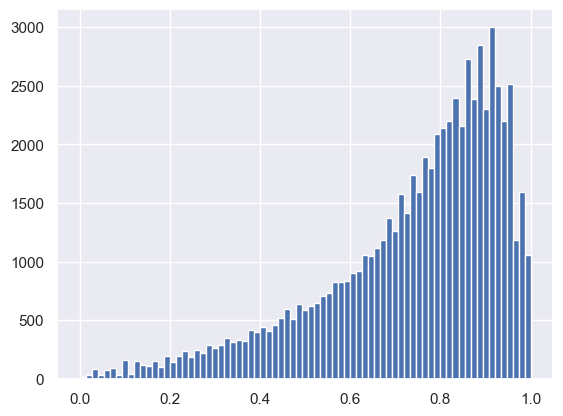

In [16]:
# Plotting a histogram of CCF
plt.hist(loan_data_defaults['CCF'], bins = 75)

Histogram Analysis of CCF

The histogram of the **Credit Conversion Factor (CCF)** shows a distinct right-skewed distribution with the following key features:

#### 1. **Right-Skewed Distribution**:
- **Long left tail**: Most of the CCF values are concentrated around 0.6–1.0, indicating that many defaults occur when the remaining principal is still high.
- **High peak on the right (0.8–1.0)**: The highest frequency bars are in the range of 0.8 to 1.0, confirming that many borrowers default while still owing 80–100% of the principal.

#### 2. **Concentration at High CCF Values**:
- **High frequency in the 0.8–1.0 range**: The highest frequency bars are in the 0.8–1.0 range, with some exceeding 2,500 in certain groups. This aligns with the high median (0.7911) and 75th percentile (0.8886), indicating many defaults occur with 80-100% of the principal remaining.
- **Peak near 1.0**: A significant portion of defaults happens early, with little to no principal repayment.

#### 3. **Low CCF Values are Rare**:
- **Very few observations below 0.2**: Most observations are above 0.2, with the smallest value being 0.0004, which is an extreme outlier. This suggests that defaults after almost full repayment of the principal are rare.

#### 4. **Shape and Dispersion**:
- The distribution **increases steadily from 0.0 to about 0.8**, peaks, and then drops off sharply at 1.0.
- The **standard deviation** (0.2001) reflects moderate dispersion in the data, indicating that while there is variation, the values are not excessively spread out.

### Implications for Basel and IFRS 9

#### 1. **Basel**:
- A high CCF increases **Exposure at Default (EAD)**, leading to higher regulatory capital requirements. Financial institutions need to assess if their current capital reserves are adequate to meet these requirements in case of defaults.

#### 2. **IFRS 9**:
- High CCF values increase **Expected Credit Loss (ECL)**, which impacts **loan loss provisions** and financial reporting. Institutions need to regularly review and monitor ECL fluctuations to ensure adequate provisions are in place.

### Risk Management

#### 1. **Data Segmentation**:
- Analyzing CCF by **loan type** (e.g., mortgages, credit cards), **customer segment** (e.g., credit score, income), and **credit policies** can help identify high-risk areas. This approach will help organizations understand which factors influence repayment behavior and segment loans by risk level.

#### 2. **Pricing**:
- Adjust **loan pricing** to reflect higher **EAD** and **potential losses**. Loans with high CCF values should be priced to account for the increased risk of default.

#### 3. **Monitoring**:
- **Monitor CCF trends** over time to detect **changes in borrower behavior** or **economic conditions**. This helps institutions identify emerging risks early and adjust their risk management strategies accordingly.

By analyzing CCF data, financial institutions can make necessary adjustments to improve their risk forecasting and optimize their credit risk management strategies.

In [17]:
# Creating a new variable showing 0 for recovery rate being 0 and 1 otherwise.
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2919436691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


In [18]:
#saving the data in a csv file
loan_data_defaults.to_csv('loan_data_defaults.csv')

###  Validation of Loss Given Default (LGD) Model and its Relevance to Basel & IFRS 9

The LGD model you described, divided into two steps based on the Recovery Rate, is a reasonable approach that aligns with international regulations like Basel and IFRS 9. Here is a detailed analysis:

---

###  LGD Model Analysis in Two Steps

#### **Step 1: When the Recovery Rate ≥ 0**
- **Model**: Logistic Regression.
- **Reason**: The Recovery Rate falls within the range [0, 1], which suits logistic regression for predicting probabilities.
- **Application**: Estimating recovery rates in typical default cases.

#### **Step 2: When the Recovery Rate ≥ 1**
- **Model**: Linear Regression.
- **Reason**: The Recovery Rate may exceed 1 in cases of over-recovery (e.g., through collateral or penalties). Linear regression is appropriate to model this unbounded relationship.
- **Application**: Handling cases where recovery exceeds the principal amount, typically found in collateralized loans or special terms.

---

###  Relevance to Basel and IFRS 9

#### **Basel II/III – IRB (Internal Ratings-Based) Approaches**
- **Advanced IRB (A-IRB)**: Banks build their own models for estimating PD (Probability of Default), LGD, and EAD (Exposure at Default).
- **Foundation IRB (F-IRB)**: Banks estimate PD internally but use regulatory values for LGD and EAD.
- **Application**: The two-step LGD model helps banks accurately estimate losses in various scenarios, supporting the calculation of capital requirements under Basel.

#### **IFRS 9 – Expected Credit Loss (ECL)**
- **Requirement**: Banks must estimate ECL based on three factors: PD, LGD, and EAD.
- **Application**: The two-step LGD model aids in accurately estimating expected credit losses, helping banks in provisioning and financial reporting.

---

###  Conclusion

Our two-step LGD model is a solid approach that aligns with international standards and helps banks accurately estimate losses in different default scenarios. Implementing this model will assist banks in calculating regulatory capital requirements under Basel and in provisioning under IFRS 9, thus improving credit risk management.


### Step 1 - Logistic

In [19]:
# LGD model step 1 datasets: recovery rate 0 or greater than 0.
# Considering a set of inputs [all cols except recovery rate and CCF] and outputs[recovery_rate_0_1]. Splits the inputs and the targets into four dataframes:
# Inputs - Train n Test, Targets - Train n Test
lgd_X_S1 = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgs_Y_S1 = loan_data_defaults['recovery_rate_0_1']

lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test = train_test_split(lgd_X_S1, lgs_Y_S1, test_size = 0.2, random_state = 42)

In [20]:
# List of all X variables for the models.
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [21]:
# List of the dummy X variables, avoiding dummy trick reference categories. 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [22]:
# Here we keep only the variables we need for the model.
lgd_X_S1_train = lgd_X_S1_train[features_all]
# Here we remove the dummy variable reference categories.
lgd_X_S1_train = lgd_X_S1_train.drop(features_reference_cat, axis = 1)

In [23]:
lgd_X_S1_train.isnull().sum()
# Check for missing values. We check whether the value of each row for each column is missing or not,
# then sum accross columns.

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

In [25]:
# As there is no built-in method to calcualte P values for 
#  sklearn logistic regression

# Build a Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [26]:
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_1 = LogisticRegression_with_p_values()

# Estimating the coefficients of the object from the 'LogisticRegression' class
# with X (independent variables) from the first dataframe
# and Y (dependent variables) from the second dataframe.
reg_lgd_st_1.fit(lgd_X_S1_train, lgd_Y_S1_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Stores the names of the columns of a dataframe in a variable.
feature_name = lgd_X_S1_train.columns.values

In [28]:
# Creating a df with a column 'Feature name' and values of the 'feature_name' variable.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a new column called 'Coefficients',
# with row values the transposed coefs from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
# Increasing the index of every row of the df with 1.
summary_table.index = summary_table.index + 1
# Assigning values of the row with index 0 of the df.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Sorts the df by index.
summary_table = summary_table.sort_index()
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_1.p_values
# We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' df, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values

summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.383029e-04,NaN
1,grade:A,-5.387386e-05,9.993638e-01
2,grade:B,-1.086164e-04,9.984167e-01
3,grade:C,-2.896128e-04,9.956200e-01
4,grade:D,7.714080e-06,9.998883e-01
5,grade:E,4.596155e-05,9.993970e-01
6,grade:F,1.439410e-04,9.983631e-01
7,home_ownership:MORTGAGE,-1.345625e-04,9.946729e-01
8,home_ownership:NONE,2.458410e-06,9.999966e-01
9,home_ownership:OTHER,1.767602e-06,9.999962e-01


### Testing the model

In [29]:
# Here we keep only the variables [features_all] that we need for the model.
lgd_X_S1_test = lgd_X_S1_test[features_all]
# Then we remove the dummy variable reference categories.
lgd_X_S1_test = lgd_X_S1_test.drop(features_reference_cat, axis = 1)

In [30]:
# Calculating the predicted vals for the Y (targets) given X (inputs)
y_hat_test_lgd_step_1 = reg_lgd_st_1.model.predict(lgd_X_S1_test)

In [31]:
y_hat_test_lgd_step_1

array([0, 1, 1, ..., 1, 1, 1])

In [32]:
# Calculates the predicted probability for Y (targets) given X (inputs)
y_hat_test_proba_lgd_step_1 = reg_lgd_st_1.model.predict_proba(lgd_X_S1_test)

In [33]:
# arrays of predicted class probabilities
# first val of arrays  is the probability for the observation belonging to the first class, i.e. 0,
# and the second value is the probability for the observation belonging to 1
y_hat_test_proba_lgd_step_1

array([[0.5031132 , 0.4968868 ],
       [0.42495936, 0.57504064],
       [0.43431035, 0.56568965],
       ...,
       [0.38585964, 0.61414036],
       [0.23830796, 0.76169204],
       [0.36648948, 0.63351052]])

In [34]:
# we consider only the probabilities for being 1.
y_hat_test_proba_lgd_step_1 = y_hat_test_proba_lgd_step_1[: ][: , 1]

In [35]:
y_hat_test_proba_lgd_step_1

array([0.4968868 , 0.57504064, 0.56568965, ..., 0.61414036, 0.76169204,
       0.63351052])

In [36]:
lgd_Y_S1_test_temp = lgd_Y_S1_test

In [37]:
# resetting the index of a dataframe.
lgd_Y_S1_test_temp.reset_index(drop = True, inplace = True)

In [38]:
# Concatenating two dataframes.
df_actual_predicted_probs = pd.concat([lgd_Y_S1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_step_1)], axis = 1)

In [39]:
df_actual_predicted_probs.columns = ['lgd_targets_step_1_test', 'y_hat_test_proba_lgd_step_1']

In [40]:
# Making the indices eqv to each other
df_actual_predicted_probs.index = lgd_X_S1_test.index

In [41]:
df_actual_predicted_probs.head()

,lgd_targets_step_1_test,y_hat_test_proba_lgd_step_1
170605,0,0.496887
414902,1,0.575041
140122,0,0.565690
56346,0,0.575137
173837,1,0.656932


### Estimating the accuracy of the model

In [42]:
tr = 0.5
# Indicator column created to give '1' for the cases where predicted proba is greater than threshold
df_actual_predicted_probs['y_hat_test_lgd_step_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'] > tr, 1, 0)

In [43]:
# Creating a cross-table, a Confusion Matrix where the actual vals are displayed by rows and the predicted vals by columns.
pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_lgd_step_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,2103,3959
1,1544,6207


In [44]:
# Gettign rates by dividing values by the tot number of observations,
cmatrix_p = pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], \
                        df_actual_predicted_probs['y_hat_test_lgd_step_1'], \
                        rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
cmatrix_p

Predicted,0,1
Actual,,
0,0.152248,0.286614
1,0.111779,0.449359


15.22% of the total observations were True Negatives (TN). - non default

44.93% of the total observations were True Positives (TP). - default

In [45]:
# Calculating accuracy of the model = sum of the diagonal rates.
cmatrix_p.iloc[0, 0] + cmatrix_p.iloc[1, 1]

0.6016071816404835

The model's overall accuracy is 60.1%, which means it correctly predicted the outcomes (default or no default) for 60.1% of the observations. 

In [46]:
# Getting Receiver Operating Characteristic (ROC) Curve: the false positive rates, the true positive rates, and the thresholds.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])

Text(0.5, 1.0, 'ROC curve')

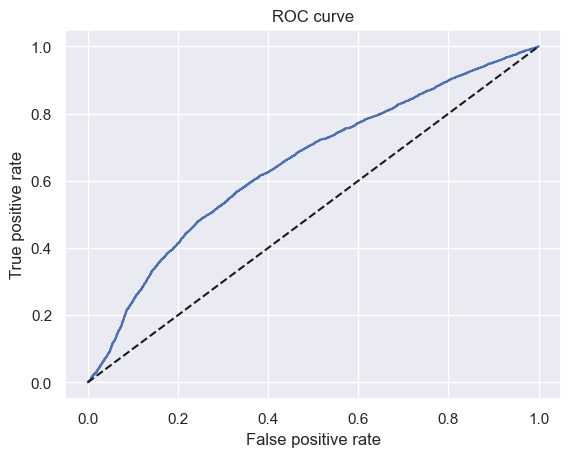

In [47]:
# We plot the ROC: false positive rate along the x-axis and the true positive rate along the y-axis,
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [48]:
# Calculating the Area Under the Receiver Operating Characteristic Curve (AUROC)
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])
AUROC

0.6485083756500423

0.648 indicates that the model has moderate discriminatory power. It performs better than random guessing but leaves room for improvement.

### Saving the Model

In [49]:
# Exporting our model to a 'SAV' file
pickle.dump(reg_lgd_st_1, open('lgd_model_step_1.sav', 'wb'))

### Step 2 - Linear

In [50]:
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.
lgd_step_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [51]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_X_S2 = lgd_step_2_data.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgd_Y_S2 = lgd_step_2_data['recovery_rate']
# splitting Inputs - Train + Test and  Targets - Train + Test.
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = train_test_split(lgd_X_S2, lgd_Y_S2, test_size = 0.2, random_state = 42)
# freeing the memory used by following arrays
lgd_x_S2, lgd_Y_S2  = [],[]

In [52]:
# keeping the variables needed for the model.
lgd_X_S2_train = lgd_X_S2_train[features_all]
# removing the dummy variable reference categories.
lgd_X_S2_train = lgd_X_S2_train.drop(features_reference_cat, axis = 1)

In [53]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [54]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [55]:
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [61]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stat
import numpy as np

# Custom LinearRegression class that also calculates t-statistics and p-values
class LinearRegressionWithStats(LinearRegression):
    def __init__(self, fit_intercept=True, copy_X=True, n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs)

    def fit(self, X, y, n_jobs=1):
        super().fit(X, y, n_jobs)
        
        # Calculate the Sum of Squared Errors (SSE) and Standard Error (SE)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        
        # Calculate t-statistics and p-values
        self.t = self.coef_ / se
        self.p = 2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        
        return self

# Assuming lgd_X_S2_train and lgd_Y_S2_train are already defined
# Initialize and train the custom Linear Regression model
reg_lgd_st_2 = LinearRegressionWithStats()
reg_lgd_st_2.fit(lgd_X_S2_train, lgd_Y_S2_train)


# Assuming the model has been trained and we have the coefficients, t-statistics, and p-values
coefficients = reg_lgd_st_2.coef_
t_statistics = reg_lgd_st_2.t
p_values = reg_lgd_st_2.p

# Create a summary DataFrame
summary_table = pd.DataFrame({
    'Feature': lgd_X_S2_train.columns,  # Assuming lgd_X_S2_train.columns holds feature names
    'Coefficient': coefficients,
    'P-value': p_values
})

# Display the summary table
summary_table = summary_table.round(4)  # Round values for cleaner display
print(summary_table)


                                Feature  Coefficient  P-value
0                               grade:A      -0.0804   0.0000
1                               grade:B      -0.0623   0.0000
2                               grade:C      -0.0482   0.0000
3                               grade:D      -0.0370   0.0000
4                               grade:E      -0.0226   0.0000
5                               grade:F      -0.0128   0.0007
6               home_ownership:MORTGAGE       0.0038   0.0011
7                   home_ownership:NONE       0.1498   0.0000
8                  home_ownership:OTHER      -0.0156   0.3407
9                    home_ownership:OWN       0.0093   0.0000
10     verification_status:Not Verified       0.0008   0.5531
11  verification_status:Source Verified      -0.0025   0.0440
12                          purpose:car      -0.0019   0.7005
13           purpose:debt_consolidation       0.0016   0.2526
14                  purpose:educational       0.0591   0.0000
15      

In [62]:
# Storing the names of the columns
feature_name = lgd_X_S2_train.columns.values

In [63]:
# Creating a df with a column 'Feature name' and vals in 'feature_name'
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creating a new column 'Coefficients' w row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# Increasing the index of every row of the dataframe with 1.
summary_table.index = summary_table.index + 1
# Assigning values of the row with index 0 of the dataframe.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# Sorting the dataframe by index.
summary_table = summary_table.sort_index()
# Taking the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_2.p
# Adding the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# Adding a column of 'p_values', containing the values
summary_table['p_values'] = p_values.round(3)

summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.690386e-01,NaN
1,grade:A,-8.039451e-02,0.000
2,grade:B,-6.225692e-02,0.000
3,grade:C,-4.817227e-02,0.000
4,grade:D,-3.695276e-02,0.000
5,grade:E,-2.258337e-02,0.000
6,grade:F,-1.284188e-02,0.001
7,home_ownership:MORTGAGE,3.813475e-03,0.001
8,home_ownership:NONE,1.497831e-01,0.000
9,home_ownership:OTHER,-1.559131e-02,0.341


### Model Evaluation

In [64]:
# keeping the variables needed
lgd_X_S2_test = lgd_X_S2_test[features_all]

In [65]:
# Removing the dummy variable reference categories.
lgd_X_S2_test = lgd_X_S2_test.drop(features_reference_cat, axis = 1)

In [66]:
# Calculating the predicted vals for Y given X
lgd_X_S2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [67]:
# Predicting Y given X
y_hat_test_lgd_step_2 = reg_lgd_st_2.predict(lgd_X_S2_test)

In [68]:
lgd_Y_S2_test_temp = lgd_Y_S2_test

In [69]:
# Resetting the index of a dataframe.
lgd_Y_S2_test_temp = lgd_Y_S2_test_temp.reset_index(drop = True)

In [70]:
# Calculating the correlation between actual and predicted values.
pd.concat([lgd_Y_S2_test_temp, pd.DataFrame(y_hat_test_lgd_step_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.285831
0,0.285831,1.000000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2759295871.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_Y_S2_test_temp - y_hat_test_lgd_step_2)


<Axes: xlabel='recovery_rate', ylabel='Density'>

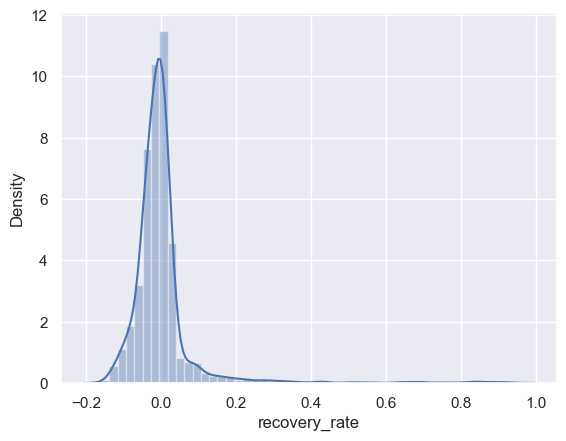

In [71]:

# Plotting the distribution of the residuals.
sns.distplot(lgd_Y_S2_test_temp - y_hat_test_lgd_step_2)

In [72]:
# Here we export our model
pickle.dump(reg_lgd_st_2, open('lgd_model_step_2.sav', 'wb'))

### Combining Steps 1 & 2

In [73]:
y_hat_test_lgd_step_2_all = reg_lgd_st_2.predict(lgd_X_S1_test)

In [74]:
y_hat_test_lgd_step_2_all

array([0.1182855 , 0.13498809, 0.10528634, ..., 0.10802221, 0.07530898,
       0.12001045])

In [75]:
# combining the predictions of the models from the two steps.y_hat_test_proba_lgd_step_1
y_hat_test_lgd = y_hat_test_lgd_step_1 * y_hat_test_lgd_step_2_all 

In [76]:
# Showing descriptive stats 
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,13813.000000
mean,0.077417
std,0.052445
min,-0.003836
25%,0.000000
50%,0.094173
75%,0.118125
max,0.244184


In [77]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [78]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,13813.000000
mean,0.077418
std,0.052443
min,0.000000
25%,0.000000
50%,0.094173
75%,0.118125
max,0.244184


### EAD Model

Exposure at Default (EAD):

EAD is the total value of the lender’s exposure to a borrower at the time of default. This includes outstanding balances and potential future draws on credit lines.

# Exposure at Default (EAD)

**EAD** is the total value of the lender’s exposure to a borrower at the time of default. This includes outstanding balances and potential future draws on credit lines. It is a key component in calculating **Expected Credit Losses (ECL)**, reflecting the potential loss exposure at the point of default.

## Basel Framework: EAD Calculation

Under the **Basel III** framework, EAD is calculated using different approaches:

- **Foundation Internal Ratings-Based (F-IRB) Approach**: Banks must use regulatory formulas to compute EAD.
- **Advanced Internal Ratings-Based (A-IRB) Approach**: Banks have more flexibility in modeling EAD, though they must meet certain regulatory requirements.

For **counterparty credit risk (CCR)**, the **Standardized Approach for Counterparty Credit Risk (SA-CCR)** is used to calculate EAD for derivatives and other off-balance-sheet exposures.

## IFRS 9: EAD in Expected Credit Losses

**IFRS 9** requires banks to estimate ECL using a forward-looking approach. While IFRS 9 does not explicitly mandate the modeling of EAD, understanding how loan exposures change over time is crucial for accurate ECL measurement. This is particularly important for loans with longer durations or those that may experience significant changes in exposure before default.

## Modeling EAD: Basel vs. IFRS 9

| **Aspect**                    | **Basel Framework**                      | **IFRS 9 Standard**                        |
|-------------------------------|------------------------------------------|--------------------------------------------|
| **Default Probability (PD)**   | Through-the-cycle (TTC)                  | Point-in-time (PiT)                        |
| **Loss Given Default (LGD)**   | Downturn LGD                             | Forward-looking LGD                        |
| **EAD Calculation**            | Prescribed formulas (e.g., CCF-K)        | Flexible, based on business practices      |
| **Undrawn Exposure Treatment** | Included using CCF-K factor              | Included if the institution has the right to refuse and exercises that right |

## Example: EAD Calculation for a Revolving Credit Facility

Consider a credit card with:

- **Outstanding balance**: $40,000
- **Undrawn limit**: $10,000
- **Credit Conversion Factor (CCF)**: 50%

Under Basel, EAD is calculated as:

$$
\text{EAD} = \text{Outstanding Balance} + (\text{Undrawn Limit} \times \text{CCF})
$$

$$
\text{EAD} = 40,000 + (10,000 \times 0.50) = 45,000
$$

Under IFRS 9, if the institution has the right to refuse undrawn portions and exercises that right, the undrawn limit may be excluded from the EAD calculation.

## Implementing EAD Modeling

For practical implementation, banks often use statistical and machine learning models to estimate EAD, considering factors such as:

- Borrower characteristics
- Loan terms and conditions
- Economic indicators

Tools like Python and R, along with libraries such as `scikit-learn`, `statsmodels`, and `pandas`, are commonly used for developing EAD models.

## Summary

- **EAD** is a key metric in assessing credit risk, representing the total exposure at the time of default.
- **Basel** provides structured approaches for calculating EAD, especially for regulatory capital purposes.
- **IFRS 9** emphasizes a forward-looking approach to ECL, requiring consideration of how exposures evolve over time.
- Modeling EAD requires careful consideration of both regulatory requirements and accounting standards to ensure accurate risk assessment.


### Linear Modelling

In [79]:
# EAD model datasets
# Splitting into Inputs - Train n Test, Targets - Train n Test.
ead_X = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
ead_Y = loan_data_defaults['CCF']
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = train_test_split(ead_X, ead_Y, test_size = 0.2, random_state = 42)
ead_X, ead_Y = [],[]

In [80]:
ead_X_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [81]:
# Keeping only the variables we need n removing the dummy var. reference categories.
ead_X_train = ead_X_train[features_all]
ead_X_train = ead_X_train.drop(features_reference_cat, axis = 1)

In [82]:
# Creating an instance of an object from the 'LogisticRegression' class.
reg_ead = LinearRegression()
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.
reg_ead.fit(ead_X_train, ead_Y_train)

LinearRegression()

In [83]:
feature_name = ead_X_train.columns.values

In [86]:
import scipy.stats as stat
import numpy as np

# EAD model datasets
# Splitting into Inputs - Train n Test, Targets - Train n Test.
ead_X = loan_data_defaults.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis=1)
ead_Y = loan_data_defaults['CCF']
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = train_test_split(ead_X, ead_Y, test_size=0.2, random_state=42)
ead_X, ead_Y = [], []

# Keeping only the variables we need and removing the dummy variable reference categories.
ead_X_train = ead_X_train[features_all]
ead_X_train = ead_X_train.drop(features_reference_cat, axis=1)

# Creating an instance of an object from the 'LinearRegression' class.
reg_ead = LinearRegression()

# Fitting the model
reg_ead.fit(ead_X_train, ead_Y_train)

# Extracting coefficients and residuals from the EAD model
coefficients_ead = reg_ead.coef_
predictions = reg_ead.predict(ead_X_train)
residuals = ead_Y_train - predictions

# Calculating the standard error (SE) of the coefficients
mse = np.mean(residuals ** 2)  # Mean Squared Error
X_transpose_X_inv = np.linalg.inv(np.dot(ead_X_train.T, ead_X_train))  # Inverse of (X'X)
se = np.sqrt(np.diagonal(mse * X_transpose_X_inv))  # Standard error of the coefficients

# Calculating t-statistics and p-values
t_stats = coefficients_ead / se
p_values = 2 * (1 - stat.t.cdf(np.abs(t_stats), df=len(ead_X_train) - len(ead_X_train.columns)))

# Create a summary table for the EAD model with coefficients and p-values
summary_table_ead = pd.DataFrame({
    'Feature': ead_X_train.columns,  # Using the feature names from ead_X_train
    'Coefficient': coefficients_ead,
    'Standard Error': se,
    't-statistic': t_stats,
    'p-value': p_values
})

# Display the summary table, rounded for cleaner display
summary_table_ead = summary_table_ead.round(4)
summary_table_ead


,Feature,Coefficient,Standard Error,t-statistic,p-value
0,grade:A,-0.2936,0.0054,-54.1052,0.0000
1,grade:B,-0.2257,0.0044,-51.1029,0.0000
2,grade:C,-0.1621,0.0043,-37.7966,0.0000
3,grade:D,-0.1131,0.0045,-25.1642,0.0000
4,grade:E,-0.0601,0.0050,-12.0916,0.0000
5,grade:F,-0.0193,0.0057,-3.3590,0.0008
6,home_ownership:MORTGAGE,-0.0076,0.0017,-4.5955,0.0000
7,home_ownership:NONE,-0.0460,0.0495,-0.9308,0.3520
8,home_ownership:OTHER,-0.0064,0.0268,-0.2373,0.8124
9,home_ownership:OWN,-0.0017,0.0027,-0.6116,0.5408


### Model Validation

In [87]:
# keeping only the variables needed and removing dummy variables
ead_X_test = ead_X_test[features_all]
ead_X_test = ead_X_test.drop(features_reference_cat, axis = 1)

In [88]:
ead_X_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [89]:
# Calculating the predicted vals
y_hat_test_ead = reg_ead.predict(ead_X_test)

In [90]:
ead_Y_test_temp = ead_Y_test

In [91]:
ead_Y_test_temp = ead_Y_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [92]:
# Calculating the correlation between actual and predicted values.
pd.concat([ead_Y_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.517602
0,0.517602,1.000000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8352\2330417334.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_Y_test - y_hat_test_ead)


<Axes: xlabel='CCF', ylabel='Density'>

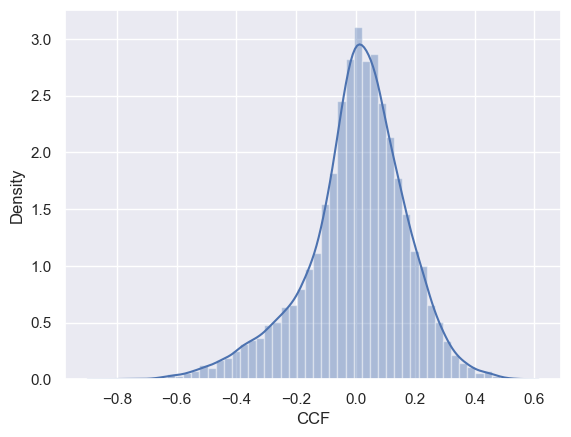

In [93]:
# Plotting the distribution of the residuals.
sns.distplot(ead_Y_test - y_hat_test_ead)

In [94]:
# Descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,13813.000000
mean,0.737575
std,0.103446
min,0.342086
25%,0.664695
50%,0.732319
75%,0.812123
max,1.002594


In [95]:
# Setting predicted values that are greater than 1 to 1 and vice versa
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [96]:
# some descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,13813.000000
mean,0.737574
std,0.103445
min,0.342086
25%,0.664695
50%,0.732319
75%,0.812123
max,1.000000


### Expected Loss calculation

In [97]:
#cleaning the memory
loan_data_preprocessed_backup = []

loan_data_defaults = []
lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test  = [], [],[],[]
lgd_step_2_data =[]
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = [],[],[],[]
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = [], [], [], []

In [98]:

# filling the missing values with zeroes.
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [99]:

# keeping the variables only we need for the model.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
# removing the dummy variable ref cats.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

## 📉 Expected Loss (EL)

Expected Loss quantifies the potential credit loss from a loan or portfolio by incorporating the **Probability of Default (PD)**, **Exposure at Default (EAD)**, and **Loss Given Default (LGD)**.

### 📌 Formula

$$
\text{EL} = \text{PD} \times \text{LGD} \times \text{EAD}
$$

Where:

- **PD (Probability of Default)**: The likelihood that a borrower will default over a given time horizon.
- **LGD (Loss Given Default)**: The percentage of the exposure that is lost when a default occurs (usually = 1 - recovery rate).
- **EAD (Exposure at Default)**: The outstanding amount at the time of default.

---

## 🧾 Under IFRS 9

- IFRS 9 requires entities to estimate **Expected Credit Losses (ECL)** using reasonable and supportable information, including historical data, current conditions, and forward-looking information.
- The EL formula is often used to calculate **12-month ECL** or **lifetime ECL**, depending on the stage of the asset.
- Source: [cpdbox.com – IFRS 9 ECL Guide](https://www.cpdbox.com/ifrs9-ecl-loss-rate-probability-of-default-examples/?utm_source=chatgpt.com)

---

## 🏛️ Under Basel II/III

- In the Basel regulatory framework, the Expected Loss is a central part of calculating **capital requirements for credit risk**.
- Banks using the Internal Ratings-Based (IRB) approach must estimate **PD**, **LGD**, and **EAD** based on internal models approved by regulators.
- Source: [Wikipedia – Loss Given Default](https://en.wikipedia.org/wiki/Loss_given_default?utm_source=chatgpt.com)

---


**Due to RAM limitations, the author was unable to proceed further with full Expected Loss computation, as merging large datasets proved impractical. Dimensionality reduction techniques such as PCA may be considered in future improvements.**
